In [1]:
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import numpy as np

from utils.function import set_seed
from config import get_params

config = get_params()
set_seed(
    seed=config['seed']
)
config

{'sampel_metric_path': './ckpt/dehazing/test_metric.json',
 'checkpoint_dir': './ckpt/dehazing',
 'data_dir': './dataset/SateHaze1k',
 'model_name': 'RSHazeNetFPNRes2NetGatedSKFusion2',
 'net_depth': (2, 2, 2),
 'crop_size': (256, 256, 3),
 'device': device(type='cuda', index=0),
 'batch_size': 14,
 'val_batch_size': 14,
 'test_batch_size': 1,
 'lr': 0.0002,
 'epochs': 1000,
 'n_workers': 0,
 'seed': 42,
 'n_class': 6}

# Dataset

In [2]:
from utils.dataloader import init_datasets

DENSITY_C = ['Haze1k_thin', 'Haze1k_moderate', 'Haze1k_thick']
train_datasets = init_datasets(
    default_path=config['data_dir'], 
    path='train', 
    density=DENSITY_C
)
val_datasets = init_datasets(
    default_path=config['data_dir'],
    path='valid', 
    density=DENSITY_C
)

# test
test_datasets = init_datasets(
    default_path=config['data_dir'],
    path='test', 
    density=DENSITY_C
)

np.random.shuffle(train_datasets)
train_datasets[:10]

==== Check Hazy Images ====
==== Check Clear Images ====
==== Check Hazy Images ====
==== Check Clear Images ====
==== Check Hazy Images ====
==== Check Clear Images ====
(3832, 2)
==== Check Hazy Images ====
==== Check Clear Images ====
==== Check Hazy Images ====
==== Check Clear Images ====
==== Check Hazy Images ====
==== Check Clear Images ====
(420, 2)
==== Check Hazy Images ====
==== Check Clear Images ====
==== Check Hazy Images ====
==== Check Clear Images ====
==== Check Hazy Images ====
==== Check Clear Images ====
(540, 2)


array([['./dataset/SateHaze1k\\Haze1k_thick/train\\input\\49-inputs_0_0.png',
        './dataset/SateHaze1k\\Haze1k_thick/train\\target\\49-targets_0_0.png'],
       ['./dataset/SateHaze1k\\Haze1k_moderate/train\\input\\81_0_0.png',
        './dataset/SateHaze1k\\Haze1k_moderate/train\\target\\81_0_0.png'],
       ['./dataset/SateHaze1k\\Haze1k_thin/train\\input\\123-inputs_1_1.png',
        './dataset/SateHaze1k\\Haze1k_thin/train\\target\\123-targets_1_1.png'],
       ['./dataset/SateHaze1k\\Haze1k_thick/train\\input\\64-inputs_0_0.png',
        './dataset/SateHaze1k\\Haze1k_thick/train\\target\\64-targets_0_0.png'],
       ['./dataset/SateHaze1k\\Haze1k_thin/train\\input\\269-inputs_1_1.png',
        './dataset/SateHaze1k\\Haze1k_thin/train\\target\\269-targets_1_1.png'],
       ['./dataset/SateHaze1k\\Haze1k_thin/train\\input\\3-inputs_1_1.png',
        './dataset/SateHaze1k\\Haze1k_thin/train\\target\\3-targets_1_1.png'],
       ['./dataset/SateHaze1k\\Haze1k_moderate/train\\input

In [3]:
# Pembuatan data loader untuk digunakan pada saat training
from utils.dataloader import DatasetGenerator
from torch.utils.data import DataLoader

train_gen = DatasetGenerator(
    file_path=train_datasets, 
    input_size=config['crop_size'][:-1], 
    train=True, 
    color_format="RGB"
)

val_gen = DatasetGenerator(
    file_path=val_datasets, 
    input_size=config['crop_size'][:-1], 
    train=False, 
    color_format="RGB"
)

test_gen = DatasetGenerator(
    file_path=test_datasets, 
    input_size=config['crop_size'][:-1], 
    train=False, 
    color_format="RGB"
)

dataloaders = {
    'train': DataLoader(
        train_gen, 
        batch_size=config['batch_size'], 
        shuffle=True, 
        num_workers=config['n_workers'], 
        pin_memory=True, 
        drop_last=True
    ),
    'val': DataLoader(
        val_gen, 
        batch_size=config['val_batch_size'], 
        shuffle=False, 
        num_workers=config['n_workers'], 
        pin_memory=True, 
        drop_last=False
    ),
    'test': DataLoader(
        test_gen, 
        batch_size=config['test_batch_size'], 
        shuffle=True, 
        num_workers=config['n_workers'], 
        pin_memory=True
    ),
}

phase_list = [i for i in dataloaders.keys() if i != 'test']
phase_list

['train', 'val']

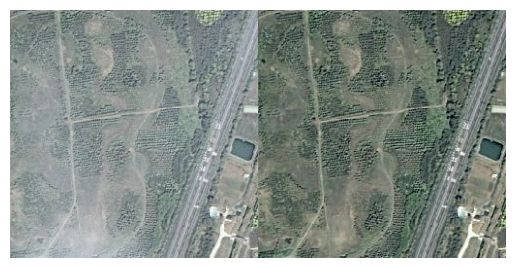

In [4]:
import matplotlib.pyplot as plt

x, y = next(iter(dataloaders['test']))
plt.axis('off')
plt.imshow(np.concatenate([
    x[0].detach().cpu().numpy().transpose((1, 2, 0)),
    y[0].detach().cpu().numpy().transpose((1, 2, 0))
], axis=1))

# Model

In [5]:
from net.RSHazeFPNPlusPlus import RSHazeNet
from thop import clever_format, profile
from torchsummary import summary

model = RSHazeNet(
    in_chans=3, 
    out_chans=4,
    dim=32,
    depths=config['net_depth'],
).to(config['device'])
macs, params = profile(model, inputs=(x.to(config['device']), ))
macs, params = clever_format([macs, params], "%.3f")
print('macs', macs)
print('params', params)
summary(model, config['crop_size'][::-1], device=config['device'])

D:\WindowsApp\miniconda3\envs\pytorch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pixelshuffle.PixelShuffle'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
macs 11.067G
params 920.672K
Layer (type:depth-idx)                        Output Shape              Param #
├─OverlapPatchEmbed: 1-1                      [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                            [-1, 32, 256, 256]        864
├─Sequential: 1-2                             [-1, 32, 256, 256]        --
|    └─ConvBlock: 2-2                         [-1, 32, 256, 256]        --
|    

Layer (type:depth-idx)                        Output Shape              Param #
├─OverlapPatchEmbed: 1-1                      [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                            [-1, 32, 256, 256]        864
├─Sequential: 1-2                             [-1, 32, 256, 256]        --
|    └─ConvBlock: 2-2                         [-1, 32, 256, 256]        --
|    |    └─Res2NetBottleneck: 3-1            [-1, 32, 256, 256]        3,552
|    └─ConvBlock: 2-3                         [-1, 32, 256, 256]        --
|    |    └─Res2NetBottleneck: 3-2            [-1, 32, 256, 256]        3,552
├─Downsample: 1-3                             [-1, 64, 128, 128]        --
|    └─Sequential: 2-4                        [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-3                       [-1, 16, 256, 256]        4,608
|    |    └─PixelUnshuffle: 3-4               [-1, 64, 128, 128]        --
├─Sequential: 1-4                             [-1, 64, 128, 128]        --
|    └─Con

In [6]:
# from utils.train import train_model

# train_model(
#     dataloaders=dataloaders,
#     phase_list=phase_list, 
#     model=model,
#     optimizer_lr=config['lr'],
#     num_epochs=config['epochs'],
#     checkpoint_path=f"{config['checkpoint_dir']}/{config['model_name']}.pth",
#     resume=False,
#     device=config['device']
# )

# Testing

In [7]:
import json
import torch

checkpoint_path = f"{config['checkpoint_dir']}/{config['model_name']}.pth"

with open(f"{checkpoint_path.split('pth')[0]}json", "r") as f: 
    global_metrics = json.load(f)

last_epoch = len(global_metrics['train']['loss'])
print(f"Total epoch trained: {last_epoch}")

checkpoint = torch.load(
    f'{checkpoint_path.split("pth")[0]}_best.pth', 
    map_location=torch.device(config['device'])
)
print(f"Best Epoch-{checkpoint['best_epoch']+1}")

model.load_state_dict(checkpoint['model'])
model.eval()
print("Weights Loaded")

Total epoch trained: 1000
Best Epoch-531
Weights Loaded


In [8]:
from utils.validation import dehazing_validation


test_score = dehazing_validation(
    path=config['sampel_metric_path'],
    model=model, 
    test_datasets=test_datasets, 
    device=config['device'], 
    module=config['model_name'],
    type_data="Average"
)
print('l2: ', np.asarray(test_score['l2']).mean())
print('psnr: ', np.asarray(test_score['psnr']).mean())
print('ssim: ', np.asarray(test_score['ssim']).mean())
print('inference time', np.asarray(test_score['time']).mean())

100%|████████████████████████████████████████████████████████████████████████████████| 540/540 [01:07<00:00,  8.00it/s]

l2:  0.003487952613094994
psnr:  25.264289227238407
ssim:  0.9030563641477514
inference time 0.09350538077177825
